###### [출처]https://9bow.github.io/PyTorch-tutorials-kr-0.3.1/beginner/transfer_learning_tutorial.html

- 전이학습

전이학습(transfer learning)은 사전에 학습된 모델을 이용하여 새로운 모델 학습 

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() 

c:\Users\islab\.conda\envs\mings\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 데이터 불러오기 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

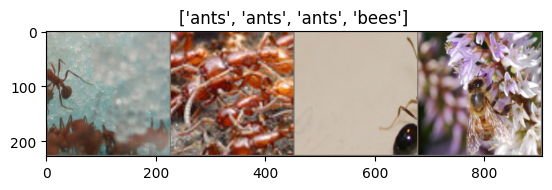

In [4]:
# 일부 이미지 시각화
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01) # .pause를 통해 loop내에서 종료될 수 있게 함


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [40]:
def train_model(model, criterion, optimizer, scheduler, acc_list, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # validation으로 적용

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # .zero_grad()를 통한 gradient 초기화
                optimizer.zero_grad() 

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            acc_list.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) #deepcopy를 통해 내부 객체까지 모두 복사
        print()

# 학습 상황 시각화
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
# 모델 예측값 시각화

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

In [41]:
# Finetuning
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\islab\.conda\envs\mings\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\islab\.conda\envs\mings\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
model_A_acc = []
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,model_A_acc,
                       num_epochs=25)
print(model_A_acc)

Epoch 0/24
----------
train Loss: 0.5206 Acc: 0.7787
val Loss: 0.2927 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.3887 Acc: 0.8320
val Loss: 0.2747 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.5989 Acc: 0.7951
val Loss: 0.3284 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.5617 Acc: 0.8238
val Loss: 0.2347 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3778 Acc: 0.8566
val Loss: 0.2101 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.3426 Acc: 0.8689
val Loss: 0.1922 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.2420 Acc: 0.8934
val Loss: 0.1995 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.2953 Acc: 0.8770
val Loss: 0.1582 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3334 Acc: 0.8689
val Loss: 0.1750 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2829 Acc: 0.8893
val Loss: 0.1899 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2702 Acc: 0.9057
val Loss: 0.2102 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2777 Acc: 0.8811
val Loss: 0.2359 Acc: 0.9150

Ep

In [45]:
# pretrain 사용 X 버전 (사용하는 것에 비해 24%정도 성능이 떨어짐)
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_B_acc = []

if use_gpu:
    model_ft = model_ft.cuda()

# # 파라미터 수 계산
# trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
# print(f"Trainable parameters: {trainable_params}")

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,model_B_acc,
                       num_epochs=25)

c:\Users\islab\.conda\envs\mings\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\islab\.conda\envs\mings\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\islab\.conda\envs\mings\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See

Epoch 0/24
----------
train Loss: 0.7287 Acc: 0.5328
val Loss: 0.7116 Acc: 0.6078

Epoch 1/24
----------
train Loss: 0.7341 Acc: 0.5984
val Loss: 0.6572 Acc: 0.6275

Epoch 2/24
----------
train Loss: 0.6807 Acc: 0.6475
val Loss: 0.7944 Acc: 0.5817

Epoch 3/24
----------
train Loss: 0.7357 Acc: 0.6516
val Loss: 0.7466 Acc: 0.6078

Epoch 4/24
----------
train Loss: 0.7966 Acc: 0.5656
val Loss: 0.6117 Acc: 0.7059

Epoch 5/24
----------
train Loss: 0.7081 Acc: 0.6270
val Loss: 0.5661 Acc: 0.7190

Epoch 6/24
----------
train Loss: 0.6034 Acc: 0.6803
val Loss: 0.5857 Acc: 0.6993

Epoch 7/24
----------
train Loss: 0.6211 Acc: 0.6557
val Loss: 0.5866 Acc: 0.7124

Epoch 8/24
----------
train Loss: 0.6022 Acc: 0.6803
val Loss: 0.6280 Acc: 0.7059

Epoch 9/24
----------
train Loss: 0.6280 Acc: 0.6475
val Loss: 0.6267 Acc: 0.7059

Epoch 10/24
----------
train Loss: 0.6145 Acc: 0.6475
val Loss: 0.5965 Acc: 0.6993

Epoch 11/24
----------
train Loss: 0.5564 Acc: 0.7172
val Loss: 0.6070 Acc: 0.7059

Ep

In [46]:
# Freezing (마지막 layer를 제외한 모든 부분을 고정시킴)
import sys
from torchsummary import summary
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Linear(num_ftrs, 2)

# parameter 학습 여부 확인
# for name, param in model_conv.named_parameters():
#     print(f"Layer: {name} | requires_grad: {param.requires_grad}")


# # 파라미터 수 계산
# trainable_params = sum(p.numel() for p in model_conv.parameters() if p.requires_grad)
# print(f"Trainable parameters: {trainable_params}")

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

c:\Users\islab\.conda\envs\mings\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\islab\.conda\envs\mings\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
model_C_acc = []
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, model_C_acc,num_epochs=25)

Epoch 0/24
----------


c:\Users\islab\.conda\envs\mings\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6472 Acc: 0.6721
val Loss: 0.4148 Acc: 0.7908

Epoch 1/24
----------
train Loss: 0.4601 Acc: 0.7746
val Loss: 0.5485 Acc: 0.8039

Epoch 2/24
----------
train Loss: 0.5368 Acc: 0.7582
val Loss: 0.1708 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4109 Acc: 0.8074
val Loss: 0.2188 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4314 Acc: 0.8279
val Loss: 0.4220 Acc: 0.8366

Epoch 5/24
----------
train Loss: 0.4420 Acc: 0.8033
val Loss: 0.1810 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3005 Acc: 0.8648
val Loss: 0.1860 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3087 Acc: 0.8730
val Loss: 0.2207 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2847 Acc: 0.8730
val Loss: 0.2338 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3556 Acc: 0.8607
val Loss: 0.2184 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3539 Acc: 0.8484
val Loss: 0.1817 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3205 Acc: 0.8484
val Loss: 0.1934 Acc: 0.9477

Epoch 12/24
----------
t

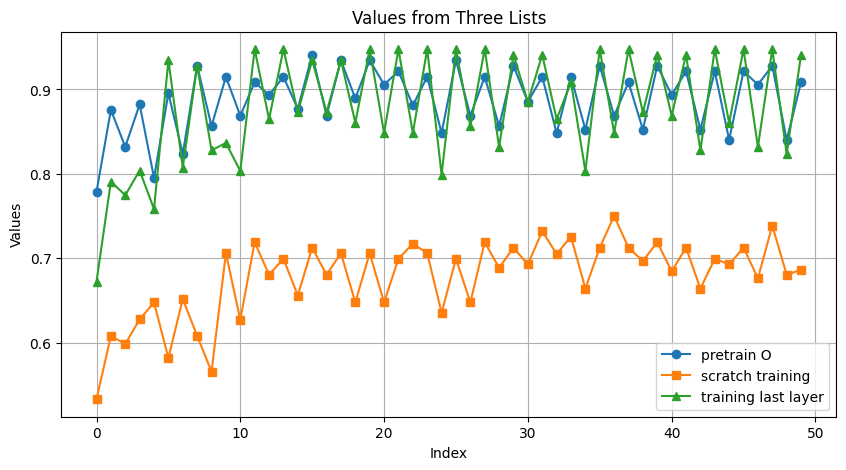

In [60]:
import matplotlib.pyplot as plt

# 그래프를 그림
plt.figure(figsize=(10, 5))

# 리스트의 모든 텐서를 numpy로 변환하는 함수
def convert_list_to_numpy(tensor_list):
    return [tensor.cpu().numpy() if tensor.is_cuda else tensor.numpy() for tensor in tensor_list]

# 각 리스트를 numpy 배열로 변환
model_A_acc = convert_list_to_numpy(model_A_acc)
model_B_acc = convert_list_to_numpy(model_B_acc)
model_C_acc = convert_list_to_numpy(model_C_acc)

# 각 리스트를 선 그래프로 표시
plt.plot(model_A_acc, label='pretrain O', marker='o')
plt.plot(model_B_acc, label='scratch training', marker='s')
plt.plot(model_C_acc, label='training last layer', marker='^')

# 그래프 제목 및 레이블 설정
plt.title('Values from Three Lists')
plt.xlabel('Index')
plt.ylabel('Values')

# 범례 표시
plt.legend()

# 그리드 추가 (선택 사항)
plt.grid(True)

# 그래프 출력
plt.show()